In [1]:
from working_with_files import *
from preprocessing import *
import pandas as pd
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from collections import Counter
import gensim
from itertools import combinations
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [2]:
def sort_by_official_dates(df):
    df1 = pd.DataFrame() # < 2008
    df2 = pd.DataFrame() # 2008 - 2013
    df3 = pd.DataFrame() # 2013 - 2016
    df4 = pd.DataFrame() # > 2016
    date1 = datetime.strptime('15-07-2008', '%d-%m-%Y').date()
    date2 = datetime.strptime('20-02-2013', '%d-%m-%Y').date()
    date3 = datetime.strptime('30-11-2016', '%d-%m-%Y').date()
    for index, row in df.iterrows():
        if int(row['Unnamed: 0']) not in [10995, 11494]:
            try:
                date = datetime.strptime(row['date'].strip(), '%d-%m-%Y').date()
            except ValueError:
                date = datetime.strptime(row['date'], '%m-%Y').date()
            if date <= date1:
                df1 = df1.append(row, ignore_index=True)
            if date > date1 and date <= date2:
                df2 = df2.append(row, ignore_index=True)
            if date > date2 and date <= date3:
                df3 = df3.append(row, ignore_index=True)
            if date > date3:
                df4 = df4.append(row, ignore_index=True)
    return df1, df2, df3, df4

# get top N terms for every topic in model
def get_top_terms(model, feature_names, n_top_terms):
    all_top_terms = []
    for topic_idx, topic in enumerate(model.components_):
        all_top_terms.append([feature_names[i] for i in topic.argsort()[:-n_top_terms - 1:-1]])
    return all_top_terms

# get topic models with num topics in range
def get_topic_models(df, n_topics_range, n_top_terms):
    documents = df.loc[:, 'text_clean']
    random_seed = 42
    
    tfidf = tfidf_vectorizer.fit_transform(documents) # make occurence matrix
    tfidf_feature_names = tfidf_vectorizer.get_feature_names() # get tfidf terms
    topic_models = []
    for k in n_topics_range:
        print('Building model', k, 'out of', n_topics_range)
        nmf = NMF(n_components=k, random_state=random_seed, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
        W = nmf.transform(tfidf)
        H = nmf.components_
        top_terms = get_top_terms(nmf, tfidf_feature_names, n_top_terms)
        topic_models.append((k, W, H, top_terms))

    return topic_models

def calculate_coherence(w2v_model, all_top_terms):
    overall_coherence = 0.0
    pair_scores = []
    for topic_top_terms in all_top_terms:
        for pair in combinations(topic_top_terms, 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    return overall_coherence / len(all_top_terms)

# build vocabulary and train word2vec model
def build_w2v_model(df):
    documents = [words.lower().split() for words in list(df['text_clean'])]
    w2v_model = gensim.models.Word2Vec(documents, size=300, min_count=10)
    return w2v_model

### code source: https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb
def plot_coherence_scores(k_values, coherences):
    fig = plt.figure(figsize=(24,7))
    # create the line plot
    ax = plt.plot(k_values, coherences)
    plt.xticks(k_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Mean Coherence")
    # add the points
    plt.scatter(k_values, coherences, s=120)
    # find and annotate the maximum point on the plot
    ymax = max(coherences)
    xpos = coherences.index(ymax)
    best_k = k_values[xpos]
    plt.annotate("top k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
    # show the plot
    plt.show()

def show_coherence_scores(topic_models, w2v_model):
    k_values = []
    coherences = []
    for (k, W, H, top_terms) in topic_models:
        # calculate the coherence based on w2v model
        k_values.append(k)
        coherences.append(calculate_coherence(w2v_model, top_terms))
        print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    plot_coherence_scores(k_values, coherences)

In [3]:
# read df and split it into 4 separate df4 based on publication date
df = pd.read_csv('mfa_texts_df.csv', sep = '\t', encoding = 'utf-8')
sorted_dfs = sort_by_official_dates(df)

In [4]:
# get unnecessary symbols to remove them from texts
symbols_to_del = generate_symbols_to_del(get_all_texts(df))
symbols_to_del.extend(list('abcdefghijklmnopqrstuvwxyz'))
symbols_to_del_upd = [symbol for symbol in symbols_to_del if symbol not in '0123456789']
print(symbols_to_del_upd)

# clean texts from unnecessary symbols
for df in sorted_dfs:
    df['text_clean'] = df['text_lemmatized'].apply(clean, args=(symbols_to_del_upd,))

['€', '<', '&', '‒', '…', '´', '?', ',', '%', '”', '.', ':', '"', ')', '－', '‑', '*', '°', '@', '#', '[', '\xad', ']', '«', '−', '！', '/', '_', '—', '(', '“', '»', '>', '·', '=', '\n', '{', '$', '–', '’', ';', '№', '`', '+', '́', '!', '―', '„', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
# get and preprocess stopwords
# source: ruscorpora.ru

stopwords_raw = get_lexicon_from_file('russian_stopwords.txt')
stopwords = []
stopwords_string = ''.join(stopwords_raw)
strings = stopwords_string.split('\t')
for string in strings:
    if string.isalpha():
        stopwords.append(string)

# lemmatize stopwords

stopwords_lemmatized = [lemmatize_pymorphy(word) for word in stopwords]
stopwords_lemmatized = list(set(stopwords_lemmatized))
stopwords = [stopword for stopword in stopwords_lemmatized if stopword.isalpha()]

stopwords.extend('''б г д е ж з й л м н п р т ф х ц ч ш щ ъ ы ь э ю
                наш твой мой свой ваш его их ее над чей такой другой между год страна государство также все отношение г-н 
                россия российский сторона де два дж мид внешнеполитический интервью министр газета иностранный дело
                катерина спецкор новость рассказывать подобный кроме министерство кстати пресс-конференция москва сайт лавров
                медведев путин сайт подробный рф s форум сердечно добрый желать приветствовать сам ясный ясность кто-то
                говорить хотеть официальный еще какой-то об лишь включая вокруг ле никакой во ясно ярмарка'''.split())

print(stopwords)

['я', 'на', 'этот', 'когда', 'не', 'очень', 'от', 'время', 'уже', 'чтобы', 'и', 'же', 'по', 'надо', 'она', 'весь', 'без', 'потом', 'до', 'есть', 'или', 'один', 'кто', 'себя', 'который', 'быть', 'ну', 'так', 'чем', 'можно', 'ни', 'для', 'тогда', 'под', 'при', 'тут', 'то', 'человек', 'через', 'если', 'бы', 'мочь', 'с', 'нет', 'вот', 'они', 'там', 'теперь', 'как', 'мы', 'ли', 'за', 'потому', 'у', 'что', 'где', 'о', 'ничто', 'даже', 'из', 'тем', 'он', 'вы', 'это', 'раз', 'здесь', 'сказать', 'тот', 'после', 'только', 'к', 'в', 'ты', 'более', 'но', 'ещё', 'а', 'б', 'г', 'д', 'е', 'ж', 'з', 'й', 'л', 'м', 'н', 'п', 'р', 'т', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'наш', 'твой', 'мой', 'свой', 'ваш', 'его', 'их', 'ее', 'над', 'чей', 'такой', 'другой', 'между', 'год', 'страна', 'государство', 'также', 'все', 'отношение', 'г-н', 'россия', 'российский', 'сторона', 'де', 'два', 'дж', 'мид', 'внешнеполитический', 'интервью', 'министр', 'газета', 'иностранный', 'дело', 'катерина', 'с

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words=stopwords, token_pattern=r"\b['\w-]+\b")
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words=stopwords, token_pattern=r"\b['\w-]+\b")

Building model 10 out of range(10, 100)
Building model 11 out of range(10, 100)
Building model 12 out of range(10, 100)
Building model 13 out of range(10, 100)
Building model 14 out of range(10, 100)
Building model 15 out of range(10, 100)
Building model 16 out of range(10, 100)
Building model 17 out of range(10, 100)
Building model 18 out of range(10, 100)
Building model 19 out of range(10, 100)
Building model 20 out of range(10, 100)
Building model 21 out of range(10, 100)
Building model 22 out of range(10, 100)
Building model 23 out of range(10, 100)
Building model 24 out of range(10, 100)
Building model 25 out of range(10, 100)
Building model 26 out of range(10, 100)
Building model 27 out of range(10, 100)
Building model 28 out of range(10, 100)
Building model 29 out of range(10, 100)
Building model 30 out of range(10, 100)
Building model 31 out of range(10, 100)
Building model 32 out of range(10, 100)
Building model 33 out of range(10, 100)
Building model 34 out of range(10, 100)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).


K=10: Coherence=0.3108
K=11: Coherence=0.3122
K=12: Coherence=0.3182
K=13: Coherence=0.3267
K=14: Coherence=0.3249
K=15: Coherence=0.3284
K=16: Coherence=0.3419
K=17: Coherence=0.3600
K=18: Coherence=0.3470
K=19: Coherence=0.3569
K=20: Coherence=0.3652
K=21: Coherence=0.3568
K=22: Coherence=0.3573
K=23: Coherence=0.3638
K=24: Coherence=0.3735
K=25: Coherence=0.3787
K=26: Coherence=0.3655
K=27: Coherence=0.3805
K=28: Coherence=0.3653
K=29: Coherence=0.3665
K=30: Coherence=0.3752
K=31: Coherence=0.3719
K=32: Coherence=0.3655
K=33: Coherence=0.3684
K=34: Coherence=0.3704
K=35: Coherence=0.3784
K=36: Coherence=0.3810
K=37: Coherence=0.3702
K=38: Coherence=0.3701
K=39: Coherence=0.3744
K=40: Coherence=0.3756
K=41: Coherence=0.3837
K=42: Coherence=0.3833
K=43: Coherence=0.3739
K=44: Coherence=0.3924
K=45: Coherence=0.3767
K=46: Coherence=0.3782
K=47: Coherence=0.3809
K=48: Coherence=0.3833
K=49: Coherence=0.3774
K=50: Coherence=0.3819
K=51: Coherence=0.3804
K=52: Coherence=0.3946
K=53: Coher

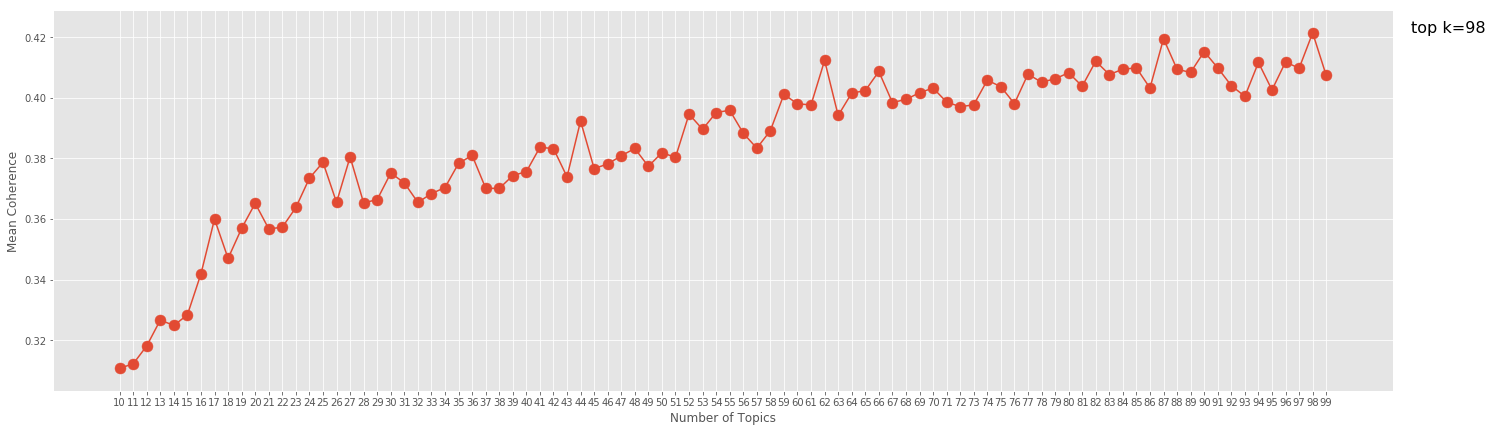

Building model 10 out of range(10, 100)
Building model 11 out of range(10, 100)
Building model 12 out of range(10, 100)
Building model 13 out of range(10, 100)
Building model 14 out of range(10, 100)
Building model 15 out of range(10, 100)
Building model 16 out of range(10, 100)
Building model 17 out of range(10, 100)
Building model 18 out of range(10, 100)
Building model 19 out of range(10, 100)
Building model 20 out of range(10, 100)
Building model 21 out of range(10, 100)
Building model 22 out of range(10, 100)
Building model 23 out of range(10, 100)
Building model 24 out of range(10, 100)
Building model 25 out of range(10, 100)
Building model 26 out of range(10, 100)
Building model 27 out of range(10, 100)
Building model 28 out of range(10, 100)
Building model 29 out of range(10, 100)
Building model 30 out of range(10, 100)
Building model 31 out of range(10, 100)
Building model 32 out of range(10, 100)
Building model 33 out of range(10, 100)
Building model 34 out of range(10, 100)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).


K=10: Coherence=0.3240
K=11: Coherence=0.3323
K=12: Coherence=0.3239
K=13: Coherence=0.3250
K=14: Coherence=0.3320
K=15: Coherence=0.3362
K=16: Coherence=0.3484
K=17: Coherence=0.3268
K=18: Coherence=0.3265
K=19: Coherence=0.3461
K=20: Coherence=0.3456
K=21: Coherence=0.3383
K=22: Coherence=0.3493
K=23: Coherence=0.3361
K=24: Coherence=0.3417
K=25: Coherence=0.3428
K=26: Coherence=0.3345
K=27: Coherence=0.3373
K=28: Coherence=0.3378
K=29: Coherence=0.3487
K=30: Coherence=0.3451
K=31: Coherence=0.3483
K=32: Coherence=0.3596
K=33: Coherence=0.3521
K=34: Coherence=0.3368
K=35: Coherence=0.3401
K=36: Coherence=0.3600
K=37: Coherence=0.3410
K=38: Coherence=0.3512
K=39: Coherence=0.3455
K=40: Coherence=0.3418
K=41: Coherence=0.3397
K=42: Coherence=0.3540
K=43: Coherence=0.3479
K=44: Coherence=0.3483
K=45: Coherence=0.3614
K=46: Coherence=0.3464
K=47: Coherence=0.3575
K=48: Coherence=0.3495
K=49: Coherence=0.3504
K=50: Coherence=0.3527
K=51: Coherence=0.3504
K=52: Coherence=0.3554
K=53: Coher

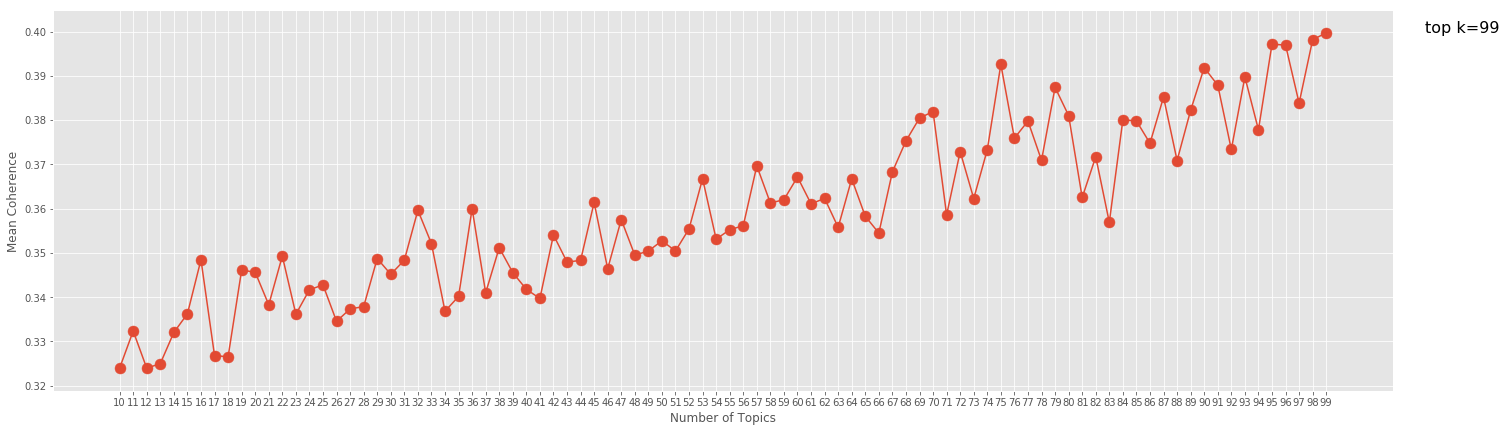

Building model 10 out of range(10, 100)
Building model 11 out of range(10, 100)
Building model 12 out of range(10, 100)
Building model 13 out of range(10, 100)
Building model 14 out of range(10, 100)
Building model 15 out of range(10, 100)
Building model 16 out of range(10, 100)
Building model 17 out of range(10, 100)
Building model 18 out of range(10, 100)
Building model 19 out of range(10, 100)
Building model 20 out of range(10, 100)
Building model 21 out of range(10, 100)
Building model 22 out of range(10, 100)
Building model 23 out of range(10, 100)
Building model 24 out of range(10, 100)
Building model 25 out of range(10, 100)
Building model 26 out of range(10, 100)
Building model 27 out of range(10, 100)
Building model 28 out of range(10, 100)
Building model 29 out of range(10, 100)
Building model 30 out of range(10, 100)
Building model 31 out of range(10, 100)
Building model 32 out of range(10, 100)
Building model 33 out of range(10, 100)
Building model 34 out of range(10, 100)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).


K=10: Coherence=0.3355
K=11: Coherence=0.3352
K=12: Coherence=0.3377
K=13: Coherence=0.3378
K=14: Coherence=0.3753
K=15: Coherence=0.3720
K=16: Coherence=0.3650
K=17: Coherence=0.3553
K=18: Coherence=0.3655
K=19: Coherence=0.3658
K=20: Coherence=0.3658
K=21: Coherence=0.3925
K=22: Coherence=0.3895
K=23: Coherence=0.3826
K=24: Coherence=0.3851
K=25: Coherence=0.3869
K=26: Coherence=0.3907
K=27: Coherence=0.3884
K=28: Coherence=0.3961
K=29: Coherence=0.3951
K=30: Coherence=0.3968
K=31: Coherence=0.3858
K=32: Coherence=0.4302
K=33: Coherence=0.3853
K=34: Coherence=0.3950
K=35: Coherence=0.3817
K=36: Coherence=0.3883
K=37: Coherence=0.3917
K=38: Coherence=0.3881
K=39: Coherence=0.3998
K=40: Coherence=0.3861
K=41: Coherence=0.3948
K=42: Coherence=0.3919
K=43: Coherence=0.3962
K=44: Coherence=0.3965
K=45: Coherence=0.3962
K=46: Coherence=0.3955
K=47: Coherence=0.4003
K=48: Coherence=0.4027
K=49: Coherence=0.4016
K=50: Coherence=0.4052
K=51: Coherence=0.3921
K=52: Coherence=0.3998
K=53: Coher

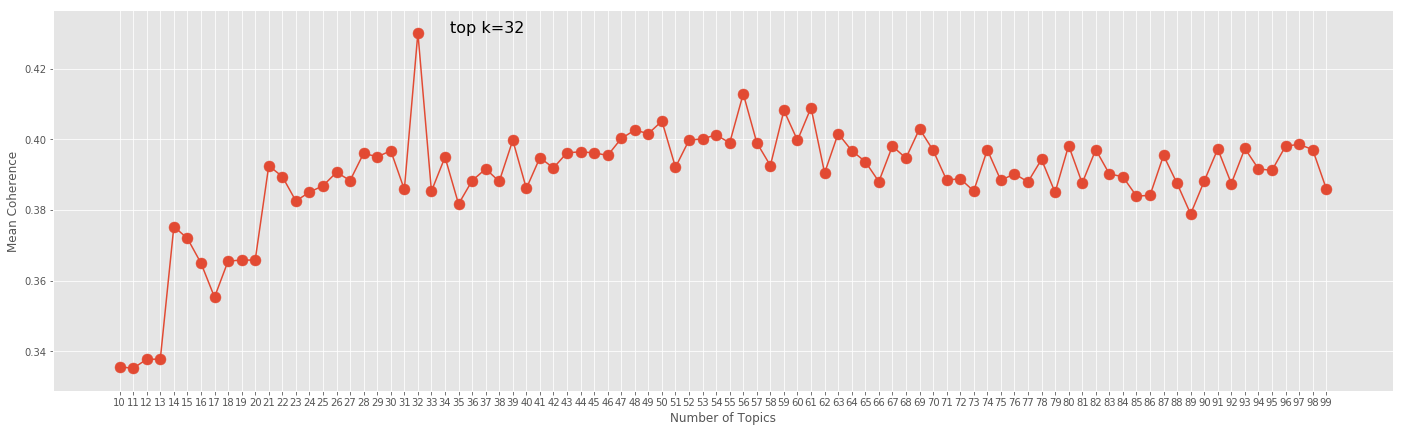

Building model 10 out of range(10, 100)
Building model 11 out of range(10, 100)
Building model 12 out of range(10, 100)
Building model 13 out of range(10, 100)
Building model 14 out of range(10, 100)
Building model 15 out of range(10, 100)
Building model 16 out of range(10, 100)
Building model 17 out of range(10, 100)
Building model 18 out of range(10, 100)
Building model 19 out of range(10, 100)
Building model 20 out of range(10, 100)
Building model 21 out of range(10, 100)
Building model 22 out of range(10, 100)
Building model 23 out of range(10, 100)
Building model 24 out of range(10, 100)
Building model 25 out of range(10, 100)
Building model 26 out of range(10, 100)
Building model 27 out of range(10, 100)
Building model 28 out of range(10, 100)
Building model 29 out of range(10, 100)
Building model 30 out of range(10, 100)
Building model 31 out of range(10, 100)
Building model 32 out of range(10, 100)
Building model 33 out of range(10, 100)
Building model 34 out of range(10, 100)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).


K=10: Coherence=0.2724
K=11: Coherence=0.2635
K=12: Coherence=0.3036
K=13: Coherence=0.3100
K=14: Coherence=0.3273
K=15: Coherence=0.3298
K=16: Coherence=0.3329
K=17: Coherence=0.3308
K=18: Coherence=0.3310
K=19: Coherence=0.3260
K=20: Coherence=0.3311
K=21: Coherence=0.3174
K=22: Coherence=0.3354
K=23: Coherence=0.3444
K=24: Coherence=0.3517
K=25: Coherence=0.3529
K=26: Coherence=0.3371
K=27: Coherence=0.3678
K=28: Coherence=0.3641
K=29: Coherence=0.3385
K=30: Coherence=0.3452
K=31: Coherence=0.3478
K=32: Coherence=0.3479
K=33: Coherence=0.3590
K=34: Coherence=0.3606
K=35: Coherence=0.3761
K=36: Coherence=0.3560
K=37: Coherence=0.3819
K=38: Coherence=0.3592
K=39: Coherence=0.3684
K=40: Coherence=0.3742
K=41: Coherence=0.3889
K=42: Coherence=0.3578
K=43: Coherence=0.3788
K=44: Coherence=0.3855
K=45: Coherence=0.3899
K=46: Coherence=0.3676
K=47: Coherence=0.4025
K=48: Coherence=0.3708
K=49: Coherence=0.3843
K=50: Coherence=0.3711
K=51: Coherence=0.3804
K=52: Coherence=0.3735
K=53: Coher

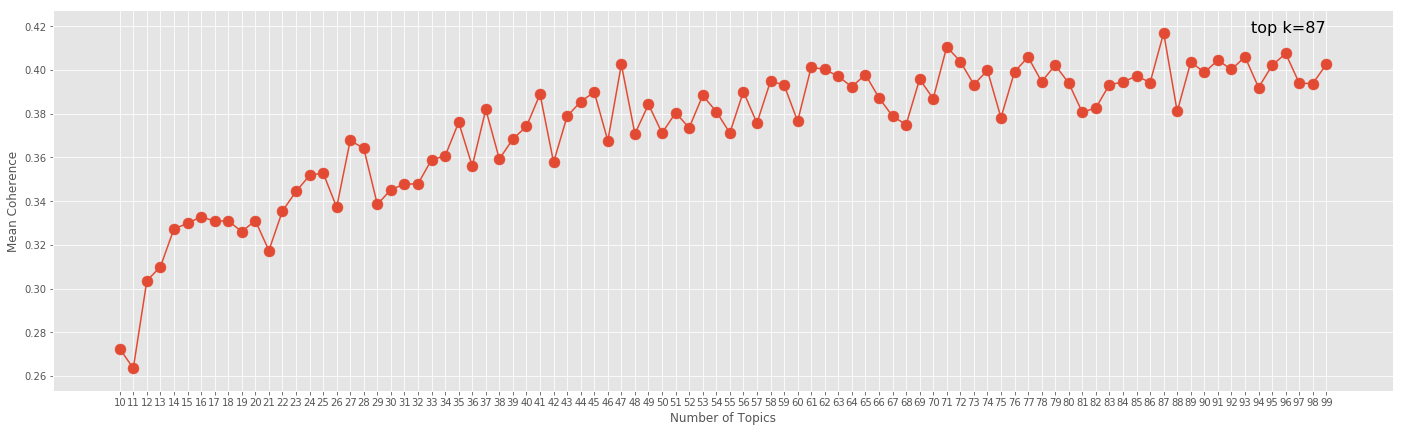

In [7]:
for df in sorted_dfs:
    topic_models = get_topic_models(df, range(10, 100), 10)
    w2v_model = build_w2v_model(df)
    show_coherence_scores(topic_models, w2v_model)